Fashion Recommendation System

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel


Data Preparation

In [2]:
path = 'C:\\Users\\Sharvari Gohane\\Documents\\AI Trend Recommendation Sytem\\fashion-dataset'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) 
dirs_names

['fashion-dataset', 'images', 'images.csv', 'styles', 'styles.csv']

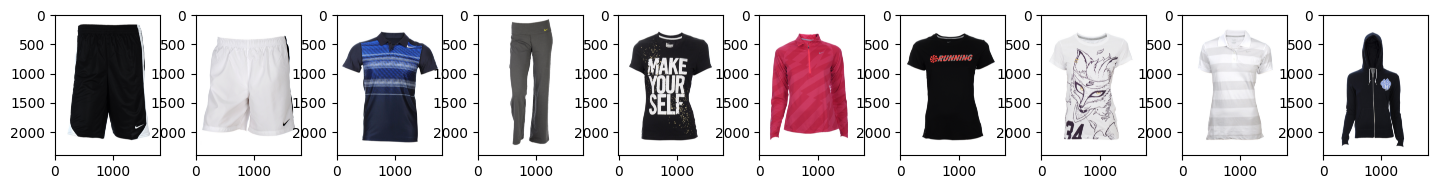

In [3]:

base_path = r'C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\fashion-dataset'

plt.figure(figsize=(20,20))
for i in range(20, 30):
    plt.subplot(6, 10, i-10+1)
    img_path = base_path + '\\images\\100' + str(i) + '.jpg' 
    cloth_img = mpimg.imread(img_path) 
    plt.imshow(cloth_img)
    plt.axis('on') 
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()


In [4]:
base_path = r'C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\fashion-dataset\\'

try:
    styles_df = pd.read_csv(base_path + "styles.csv", nrows=6000)
except pd.errors.ParserError:
    print("Error parsing CSV file. Check for malformed lines or encoding issues.")
    styles_df = pd.DataFrame()  

if not styles_df.empty:
    styles_df['image'] = styles_df['id'].astype(str) + ".jpg"

print("DataFrame Shape:", styles_df.shape)
print("\nFirst 5 rows of DataFrame:")
print(styles_df.head(5))


DataFrame Shape: (6000, 11)

First 5 rows of DataFrame:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg  


<Axes: ylabel='articleType'>

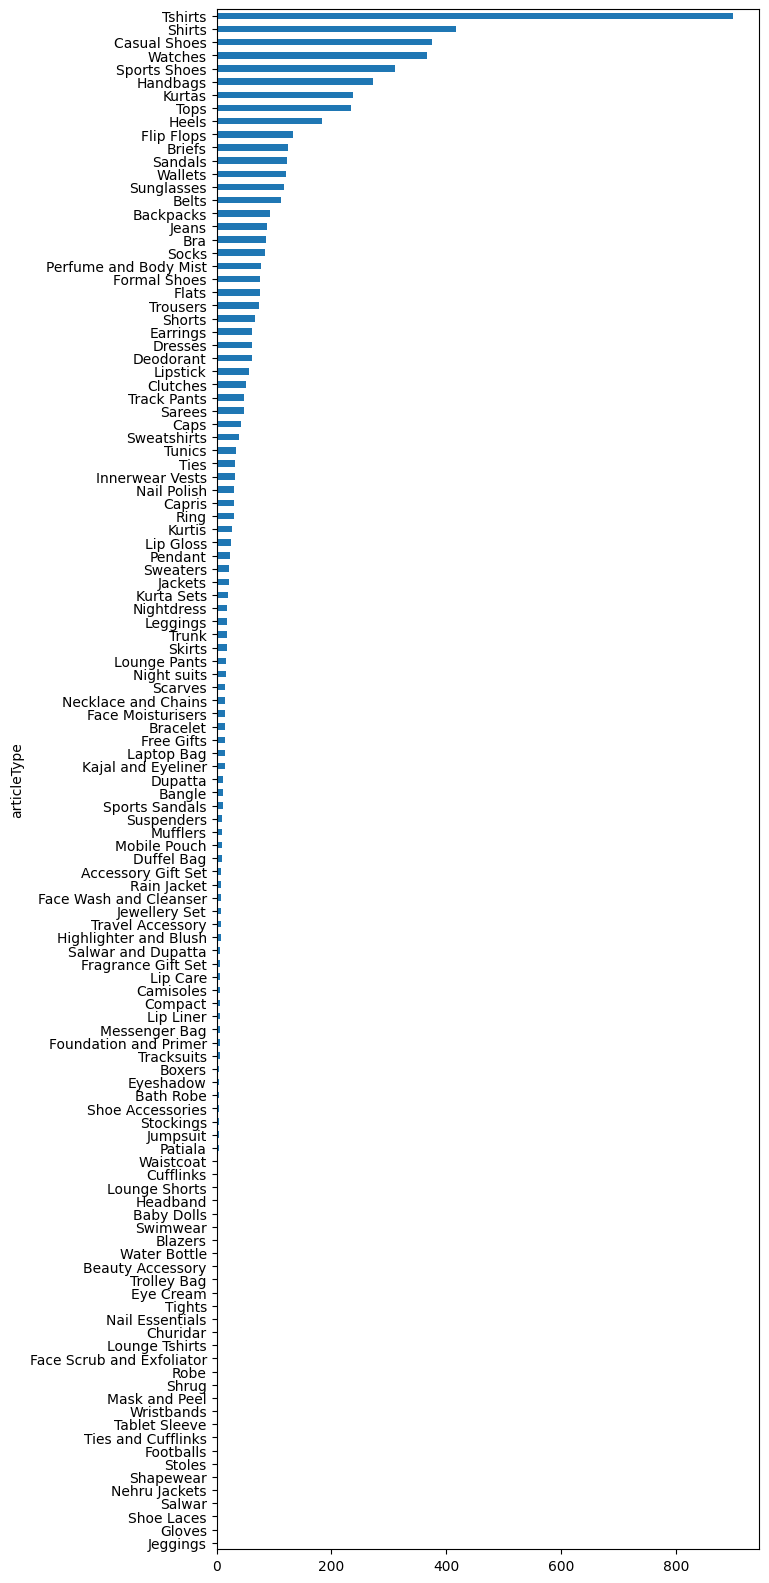

In [5]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

Modeling and Get Image Embeddings

In [6]:
img_width, img_height, chnls = 100, 100, 3

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential

# Assuming img_width, img_height, and chnls are defined correctly
img_width, img_height, chnls = 224, 224, 3

# Load the VGG16 model without the top layers
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable = False

# Create a Sequential model with VGG16 base and GlobalMaxPooling2D layer
vgg16_model = Sequential([
    vgg16,
    GlobalMaxPooling2D(data_format='channels_last')  # Ensure data_format matches input
])

# Print the model summary
vgg16_model.build(input_shape=(None, img_width, img_height, chnls))  # Explicitly build the model
vgg16_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
def img_path(img):
    return path + 'images/' + img

def predict(model, img_name):
    
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    
    img = image.img_to_array(img)

    img = np.expand_dims(img, axis=0)
    
    img = preprocess_input(img)
    return model.predict(img)

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from concurrent.futures import ThreadPoolExecutor
import os

img_width, img_height = 224, 224

def img_path(img):

    base_path = r'C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\fashion-dataset\images'
    full_path = os.path.join(base_path, img)
    return full_path

def predict(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return model.predict(img)

def process_image(model, img_name):
    return predict(model, img_name).reshape(-1)

def get_embeddings(df, model):
    with ThreadPoolExecutor() as executor:
        embeddings = list(executor.map(process_image_wrapper, df['image']))
    df_embeddings = pd.DataFrame(embeddings)
    return df_embeddings

def process_image_wrapper(img_name):
    return process_image(vgg16_model, img_name)

vgg16_model = VGG16(weights='imagenet', include_top=False)

df_embeddings = get_embeddings(styles_df, vgg16_model)

print(df_embeddings.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
print(df_embeddings.head(5))

   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   25078  25079  25080  25081  25082  25083  25084  25085  25086     25087  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  3.091668  

[5 rows x 25088 columns]


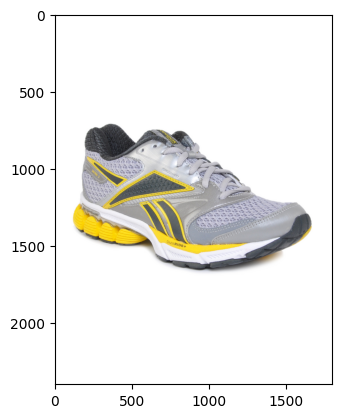

In [12]:
url="C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [13]:
# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False)

# Predict the embedding for the sample image
sample_image = predict(vgg16_model, 'C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/fashion-dataset/images/10037.jpg')

# Print the shape of the sample image embedding
print(sample_image.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
(1, 7, 7, 512)


VGG16 Model

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 331s 176ms/step - accuracy: 0.7835 - loss: 0.6370 - val_accuracy: 0.8451 - val_loss: 0.4246
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 196s 104ms/step - accuracy: 0.8638 - loss: 0.3739 - val_accuracy: 0.8604 - val_loss: 0.3846
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 203s 108ms/step - accuracy: 0.8778 - loss: 0.3369 - val_accuracy: 0.8676 - val_loss: 0.3653
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 237s 126ms/step - accuracy: 0.8868 - loss: 0.3082 - val_accuracy: 0.8752 - val_loss: 0.3563
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 223s 119ms/step - accuracy: 0.8918 - loss: 0.2938 - val_accuracy: 0.8785 - val_loss: 0.3467
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 223s 119ms/step - accuracy: 0.8977 - loss: 0.2759 - val_accuracy: 0.8731 - val_loss: 0.3519
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 313s 167ms/step - accuracy: 0.9029 - loss: 0.2570 - val_accuracy: 0.8714 - val_loss: 0.3614
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 239s 127ms/step - ac

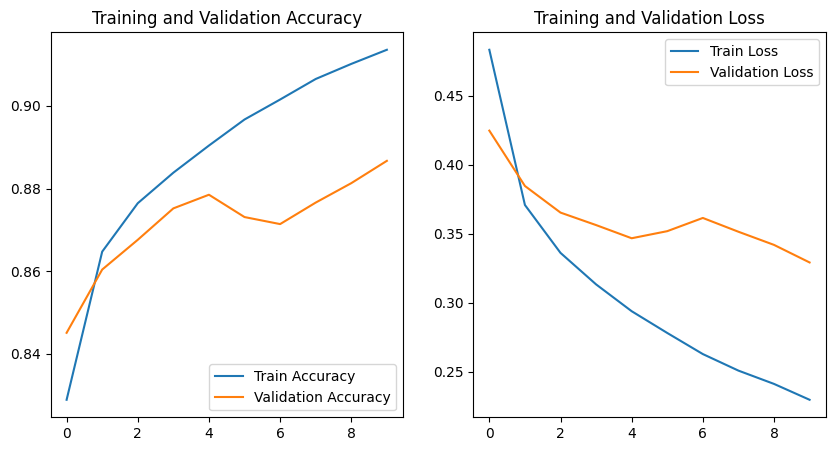

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Sample image embedding shape: (1, 1, 1, 512)


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the data to add the channel dimension and make it compatible with VGG16 (3 channels)
train_images = np.stack((train_images,) * 3, axis=-1)
test_images = np.stack((test_images,) * 3, axis=-1)

# Resize images to 48x48 as VGG16 expects 224x224 images, 
# but for performance, we use a smaller size and later will resize to 224x224 if needed.
train_images = tf.image.resize(train_images, (48, 48))
test_images = tf.image.resize(test_images, (48, 48))

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the VGG16 model weights
vgg16_model.trainable = False

# Add classification head
model = models.Sequential([
    vgg16_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Load and preprocess the sample image
img_path = 'C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/fashion-dataset/images/10037.jpg'
img = image.load_img(img_path, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict the embedding for the sample image
sample_image = vgg16_model.predict(x)

# Print the shape of the sample image embedding
print('Sample image embedding shape:', sample_image.shape)

In [16]:
import numpy as np
import pandas as pd

# Assuming sample_image is your input with shape (1, 7, 7, 512)
sample_image = np.random.rand(1, 7, 7, 512) 

reshaped_image = sample_image.reshape(sample_image.shape[0], -1)

df_sample_image = pd.DataFrame(reshaped_image)

print(df_sample_image)


      0         1         2         3         4         5         6      \
0  0.958701  0.306482  0.320408  0.005487  0.076474  0.187021  0.935102   

      7         8         9      ...     25078     25079     25080     25081  \
0  0.117158  0.856718  0.785165  ...  0.754893  0.289708  0.739683  0.697888   

      25082     25083     25084     25085     25086     25087  
0  0.528825  0.739254  0.983448  0.235796  0.668297  0.076249  

[1 rows x 25088 columns]


In [17]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)


[[20187.64722357 20285.09031796 24612.91167731 ... 27425.74759552
  20626.59951774 46038.7891965 ]]


In [18]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10037.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [19]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [20]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(3182, 1.0), (58, 0.9210553514973809), (1861, 0.9130651569732519), (4160, 0.8974573842048557), (2087, 0.891712048204325)]
Loading image: C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\images\45268.jpg
Loading image: C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\images\11188.jpg
Loading image: C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\images\45202.jpg
Loading image: C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\images\17417.jpg
Loading image: C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\images\25325.jpg


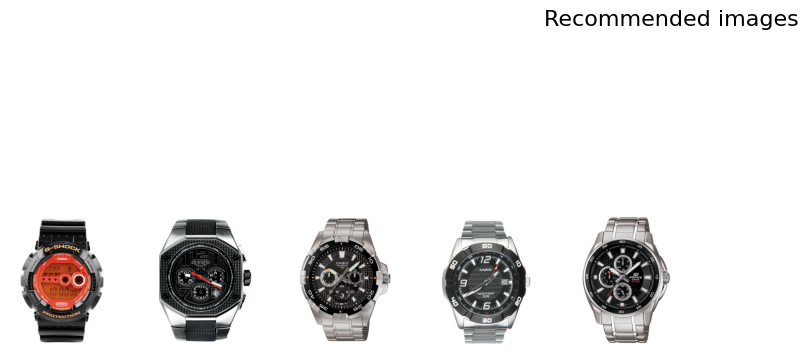

In [21]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.tolist()

# Recommended images
plt.figure(figsize=(20, 20))
j = 0
for i in recommendation_list:
    plt.subplot(6, 10, j + 1)
    full_image_path = os.path.join(path, 'images', i)
    print(f"Loading image: {full_image_path}")
    if os.path.isfile(full_image_path):
        cloth_img = mpimg.imread(full_image_path)
        plt.imshow(cloth_img)
    else:
        print(f"File not found: {full_image_path}")
        plt.text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
    plt.axis("off")
    j += 1
plt.suptitle("Recommended images", fontsize=16)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()


In [22]:
print("Shape of df_sample_image:", df_sample_image.shape)
print("Shape of df_embeddings:", df_embeddings.shape)


Shape of df_sample_image: (1, 25088)
Shape of df_embeddings: (6000, 25088)


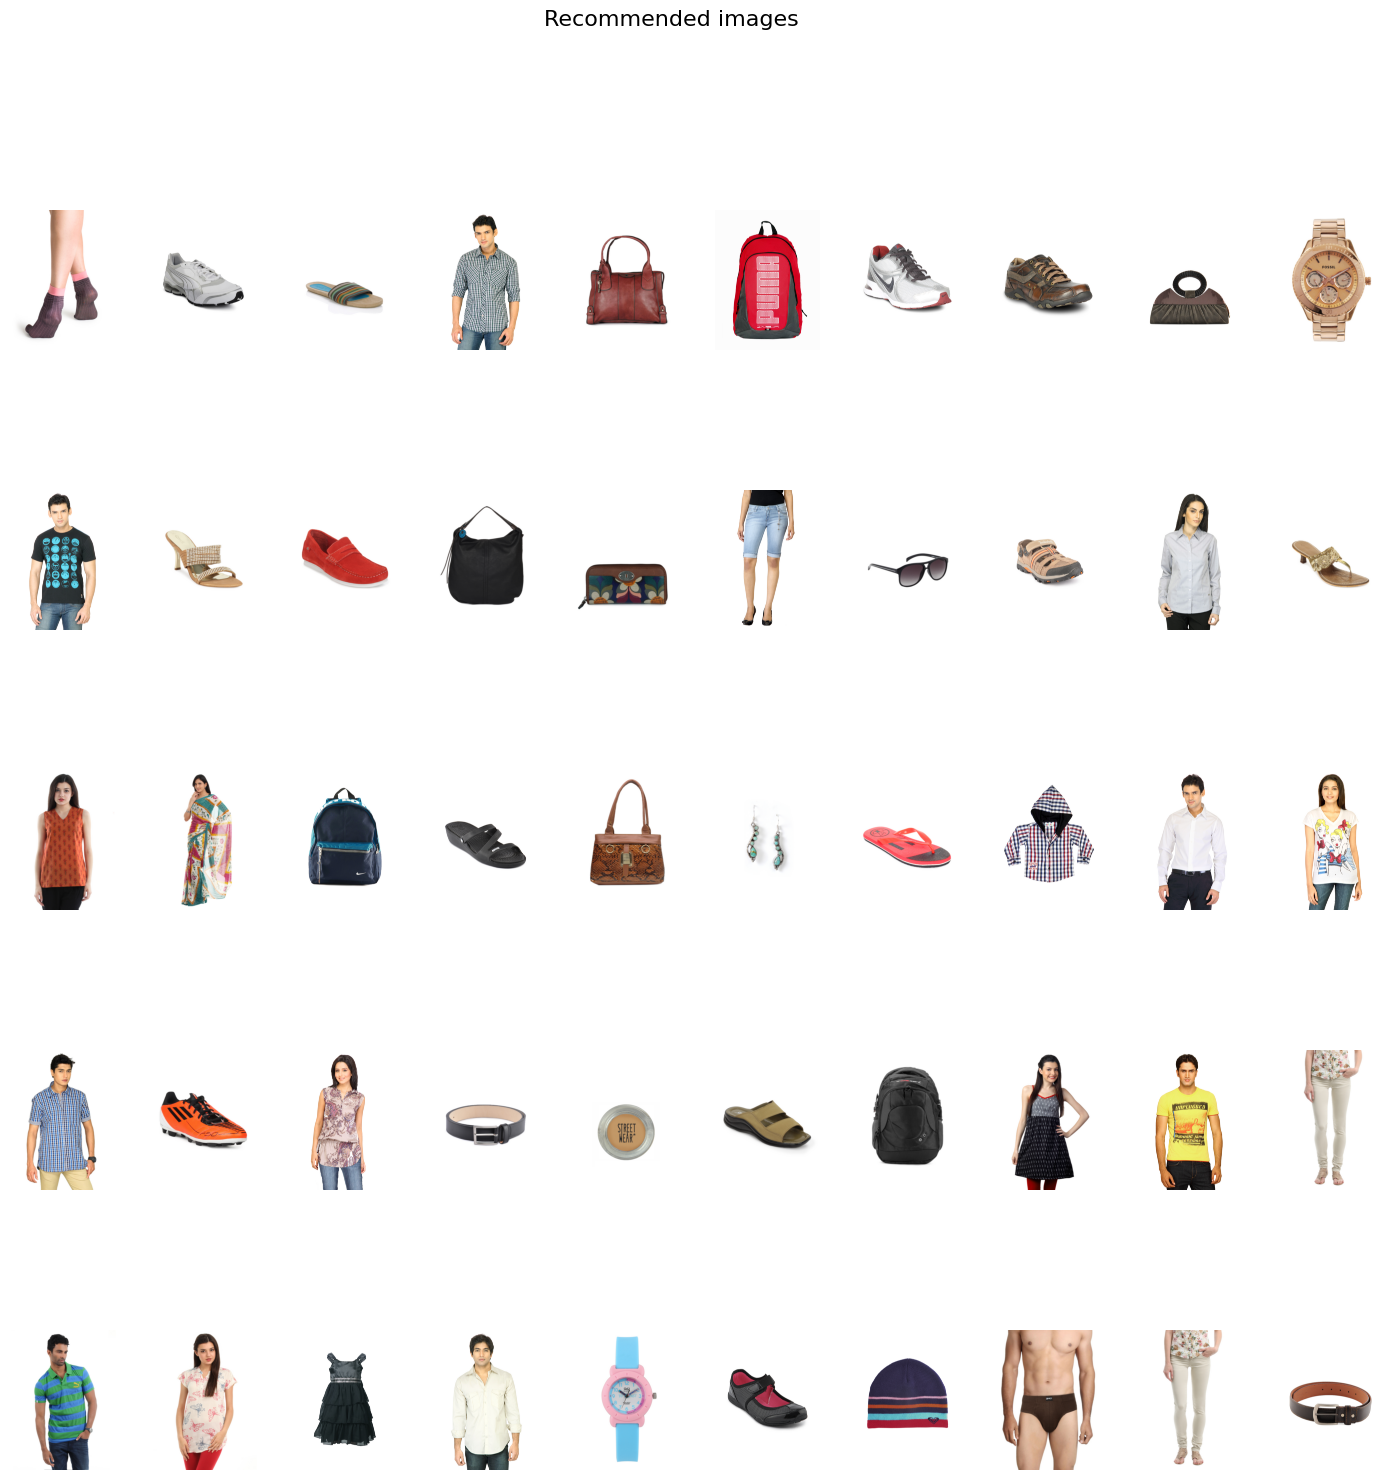

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)[:, np.newaxis]
    x_max = similarity.max(axis=1)[:, np.newaxis]
    
    # To avoid division by zero in case x_max == x_min
    norm = np.where(x_max != x_min, (similarity - x_min) / (x_max - x_min), 0)
    
    return norm

def get_recommendations(df, normalized_similarity, top_n=10):
    """ Get top N recommendations based on normalized similarity """
    recommendations = []
    for i in range(normalized_similarity.shape[0]):
        sorted_indices = np.argsort(-normalized_similarity[i])[:top_n]
        recommended_items = df.iloc[sorted_indices]['image'].values
        recommendations.append(recommended_items)
    return np.array(recommendations).flatten()

# Assuming sample_similarity is your similarity matrix
sample_similarity = np.random.rand(5, 6000)  # Replace with your actual similarity matrix

# Normalize the similarity matrix
sample_similarity_norm = normalize_sim(sample_similarity)

# Get recommendations
recommendation = get_recommendations(styles_df, sample_similarity_norm)

# Convert recommendation list to a flat list
recommendation_list = recommendation.tolist()

# Base path for images
base_path = r'C:\Users\Sharvari Gohane\Documents\AI Trend Recommendation Sytem\fashion-dataset\fashion-dataset\\'

# Plot recommended images
plt.figure(figsize=(20, 20))
j = 0
for i in recommendation_list:
    plt.subplot(6, 10, j + 1)
    try:
        cloth_img = mpimg.imread(base_path + 'images/' + i)
        plt.imshow(cloth_img)
    except FileNotFoundError:
        print(f"File not found: {base_path + 'images/' + i}")
        continue
    plt.axis("off")
    j += 1

plt.suptitle("Recommended images", fontsize=16)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()


In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model  # Correct import for plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """
    
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
        
    # Helper functions 
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df
    
    def load_model(self):
        """ Load our model """
        vgg16 = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)
    
    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity
    
    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset" + 'images/'+ i)
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()


In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

class fashion_recommendations:
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    
    def get_styles_df(self):
        """ Load a dataframe containing styles details and images """
        try:
            styles_df = pd.read_csv(self.styles_path, nrows=6000)
        except pd.errors.ParserError:
            # Handle the error or skip problematic lines here
            styles_df = pd.read_csv(self.styles_path, error_bad_lines=False)
            # Or, if you know the specific line causing the issue, you can handle it accordingly
            # e.g., use skiprows=[line_number]
        
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
        return styles_df

    
    def load_model(self):
        """ Load your image processing model (example using placeholder) """
        # Placeholder method for loading model
        return None
    
    def predict(self, model, img_path):
        """ Placeholder method for image prediction """
        # Placeholder method for image prediction
        return np.random.rand(1, 512)  # Placeholder for sample image features
    
    def get_similarity(self):
        """ Compute similarity between sample image and embeddings """
        model = self.load_model()  # Load your model
        sample_image = self.predict(model, self.img_path)  # Get features of the sample image
        sample_image = sample_image.flatten()  # Flatten to make it 1D if necessary
    
        # Assuming df_embeddings is already properly shaped and loaded
        sample_similarity = linear_kernel([sample_image], self.df_embeddings)
    
        return sample_similarity


    
    def normalize_sim(self):
        """ Placeholder method for normalizing similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity - x_min) / (x_max - x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Placeholder method for getting recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        sim_scores = list(enumerate(similarity[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:5]  # Top 5 similar items
        cloth_indices = [i[0] for i in sim_scores]
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products """
        recommendation = self.get_recommendations()
        plt.figure(figsize=(20, 10))
        for idx, img_name in enumerate(recommendation):
            img_path = f"C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/images/{img_name}"
            cloth_img = mpimg.imread(img_path)
            plt.subplot(1, 5, idx + 1)
            plt.imshow(cloth_img)
            plt.axis("off")
        plt.suptitle("Recommended Images", fontsize=16)
        plt.tight_layout()
        plt.show()


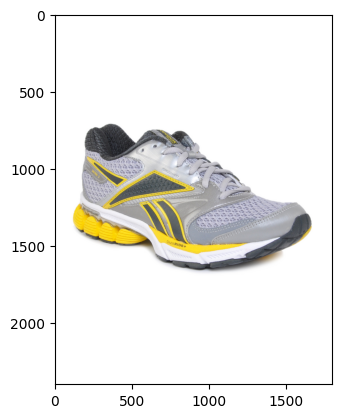

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as imread

# Define the correct path to the image
url = "C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/fashion-dataset/images/10037.jpg"

a = plt.imread(url)
plt.imshow(a)

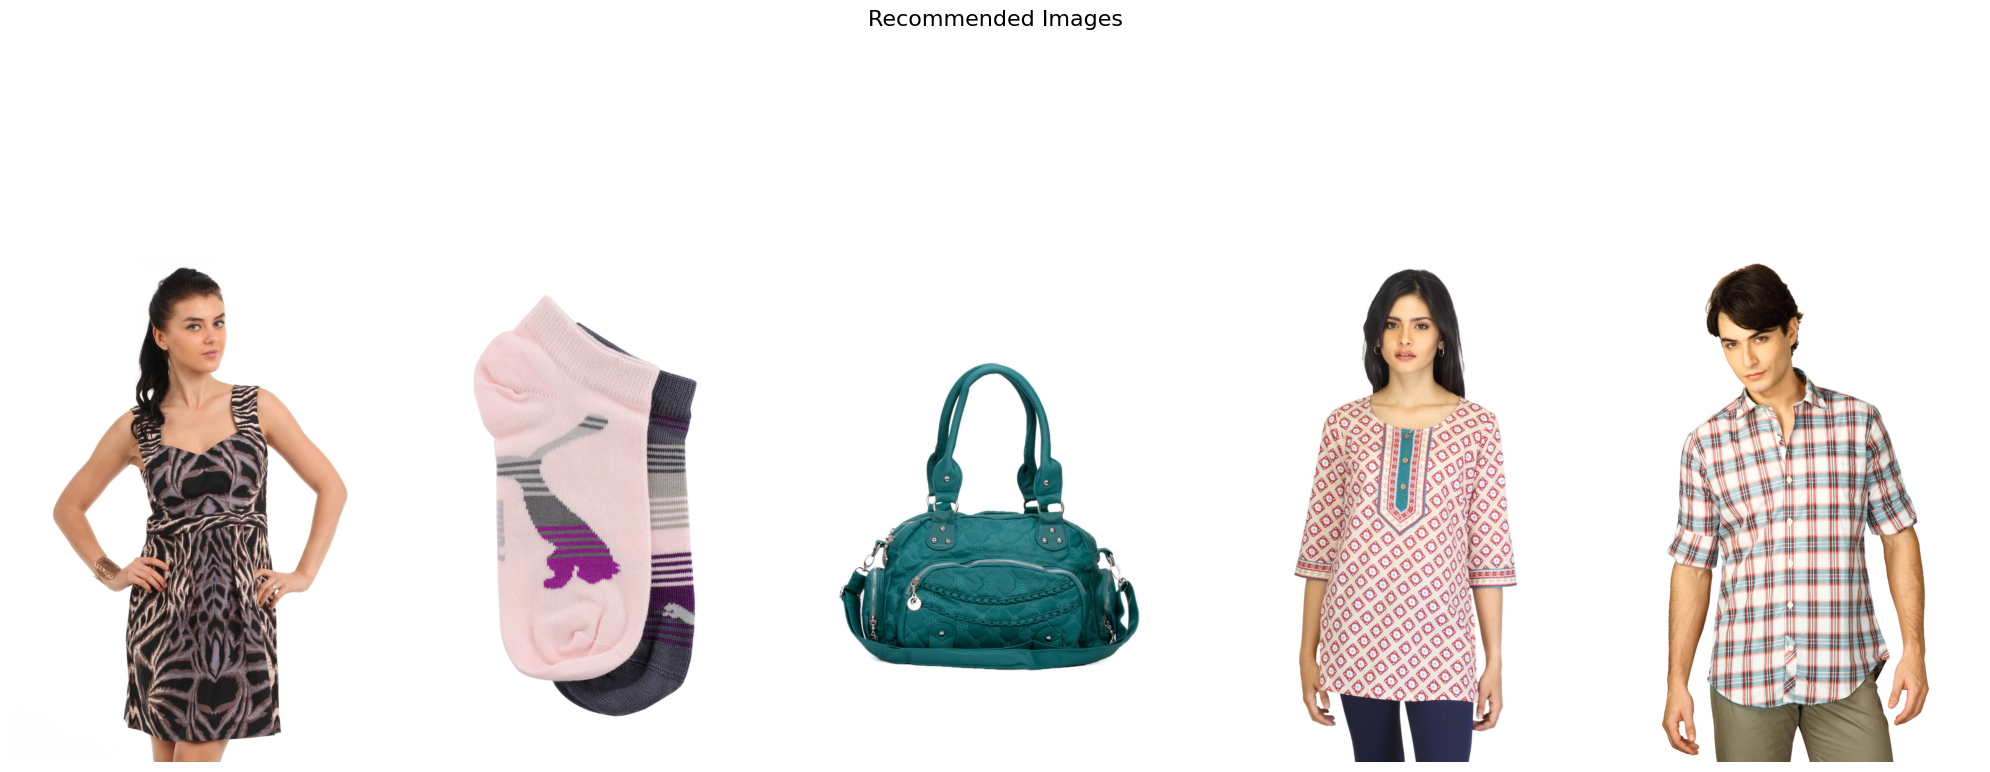

In [47]:
img_path = 'C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/images/10037.jpg'
styles_path = 'C:/Users/Sharvari Gohane/Documents/AI Trend Recommendation Sytem/fashion-dataset/fashion-dataset/styles.csv'

# Assuming you have your embeddings data (df_embeddings) properly loaded or computed
# Placeholder for df_embeddings
df_embeddings = np.random.rand(6000, 512)  # Example: Random embeddings data

# Instantiate the recommendation object
obj = fashion_recommendations(img_path, df_embeddings, styles_path)

# Print the top 5 most similar products
obj.print_recommendations()

CNN Model

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7424 - loss: 0.7012 - val_accuracy: 0.8623 - val_loss: 0.3800
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8766 - loss: 0.3422 - val_accuracy: 0.8852 - val_loss: 0.3193
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8967 - loss: 0.2804 - val_accuracy: 0.8934 - val_loss: 0.2916
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9074 - loss: 0.2483 - val_accuracy: 0.8959 - val_loss: 0.2922
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9164 - loss: 0.2238 - val_accuracy: 0.9065 - val_loss: 0.2572
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9274 - loss: 0.1998 - val_accuracy: 0.9050 - val_loss: 0.2705
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9311 - loss: 0.1856 - val_accuracy: 0.9069 - val_loss: 0.2623
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9378 -

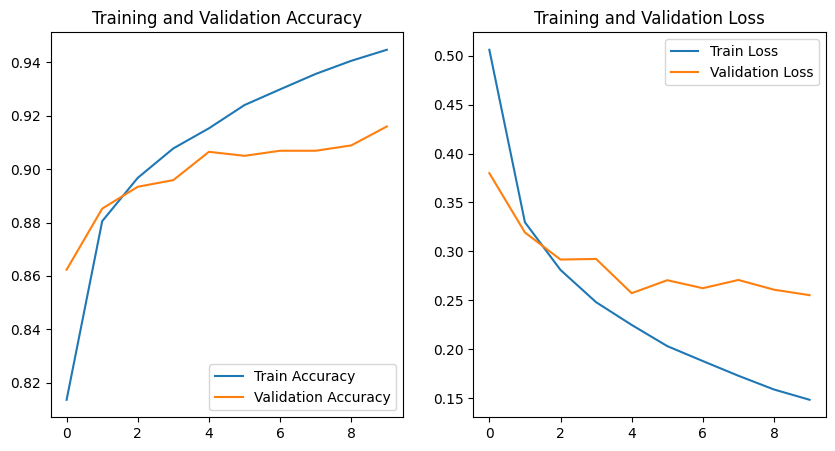

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


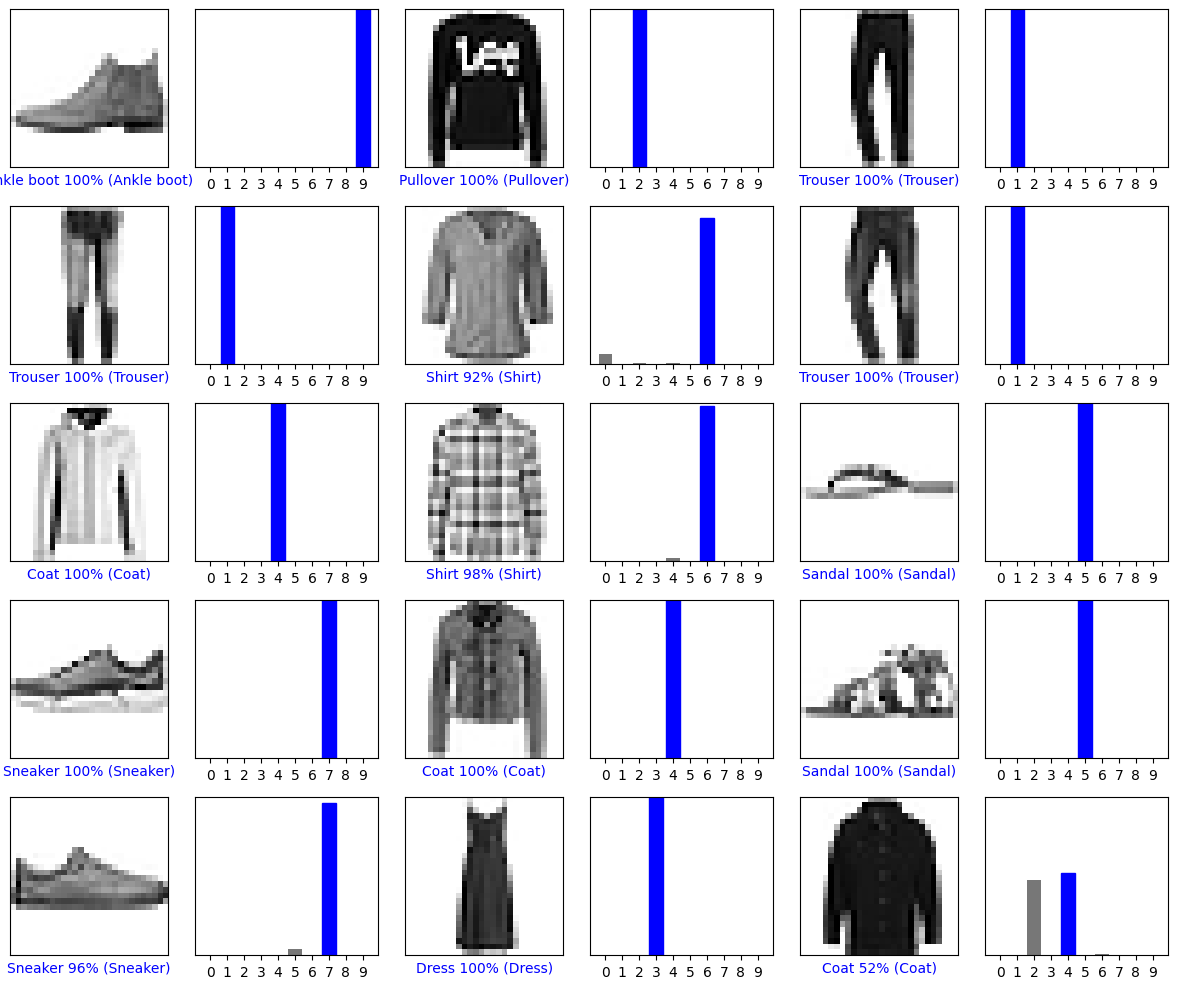

In [52]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the data to add the channel dimension
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict the labels for test images
predictions = model.predict(test_images)

# Function to plot the images along with predictions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[true_label]})", color=color)

# Function to plot the value array for predictions
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the first 15 test images, their predicted labels, and the true labels
# Color correct predictions in blue and incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, test_labels)
plt.tight_layout()
plt.show()

In [53]:
# Save the trained model
model.save('fashion_mnist_cnn.h5')

AR DEVELOPMENT

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('fashion_mnist_cnn.h5')

# Initialize MediaPipe and OpenCV
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

# Class labels for Fashion MNIST dataset
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Initialize webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Convert image to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the image and find hands
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            # Draw hand landmarks on the image
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Placeholder: Replace this part with your custom recommendation logic
            # Assuming we're using the hand landmarks to trigger fashion recommendations
            # Here we just simulate a recommendation using a random image from the dataset
            
            # Preprocess the image for the model
            input_image = cv2.resize(frame, (28, 28))
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
            input_image = input_image / 255.0
            input_image = np.reshape(input_image, (1, 28, 28, 1))
            
            # Predict the fashion item
            predictions = model.predict(input_image)
            predicted_label = np.argmax(predictions)

            # Overlay the recommended fashion item on the frame
            label_text = class_labels[predicted_label]
            cv2.putText(frame, f'Recommended: {label_text}', (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the image
    cv2.imshow("Fashion Recommendation AR", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

Virtual Try-On

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('fashion_mnist_cnn.h5')

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

clothing_images = {
    'T-shirt/top': 'path/to/tshirt_image.png',
    'Dress': 'path/to/dress_image.png',
}

def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay img_overlay onto img at (x, y) with alpha_mask"""

    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])


    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, None] / 255.0
    img_crop[:] = alpha * img_overlay_crop + (1 - alpha) * img_crop

def is_thumbs_up(landmarks):
    """Check if the hand landmarks correspond to a thumbs-up gesture"""
    thumb_tip = landmarks[mp_hands.HandLandmark.THUMB_TIP]
    thumb_ip = landmarks[mp_hands.HandLandmark.THUMB_IP]
    index_mcp = landmarks[mp_hands.HandLandmark.INDEX_FINGER_MCP]

    return thumb_tip.y < thumb_ip.y and thumb_tip.x < index_mcp.x

cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
        
            if is_thumbs_up(hand_landmarks.landmark):
         
                input_image = cv2.resize(frame, (28, 28))
                input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
                input_image = input_image / 255.0
                input_image = np.reshape(input_image, (1, 28, 28, 1))
                
                predictions = model.predict(input_image)
                predicted_label = np.argmax(predictions)

                label_text = class_labels[predicted_label]
                cv2.putText(frame, f'Recommended: {label_text}', (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                if label_text in clothing_images:
                    clothing_img = cv2.imread(clothing_images[label_text], cv2.IMREAD_UNCHANGED)
                    if clothing_img is not None:
                        
                        clothing_img_resized = cv2.resize(clothing_img, (frame.shape[1], frame.shape[0]))
                        alpha_mask = clothing_img_resized[:, :, 3] 
                        
                        wrist_x = int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x * frame.shape[1])
                        wrist_y = int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * frame.shape[0])
                    
                        overlay_x = wrist_x - clothing_img_resized.shape[1] // 2
                        overlay_y = wrist_y - clothing_img_resized.shape[0] // 2
                        
                        overlay_image_alpha(frame, clothing_img_resized[:, :, :3], overlay_x, overlay_y, alpha_mask)


    cv2.imshow("Fashion Recommendation AR", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()